In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy import linalg
from mpl_toolkits.axes_grid1 import AxesGrid

#Sparse Methods#

Most physical Hamiltonians of interest can be represented as sparse matrices, because interactions are local and/or few-body. Working with sparse matrices can often lead to big gains in memory usage and/or speed.  

There are many different sparse matrix formats supported by scipy. The ones we'll use most often are:

1. Compressed sparse row (CSR)
2. Compressed sparse column (CSC)
3. Diagonal (DIA)

Try typing sparse.ma and hit tab to auto-complete to see all the different types.

In [ ]:
sparse.csr_matrix

scipy.sparse._csr.csr_matrix

##Pauli Matrices ##

Most models we will consider in this course represent systems of spin-S degrees of freedom living on some $d$ dimensional lattice in real space with volume $V= L^d$ . For $S=1/2$, the spin on each site can be either 'up' or 'down', representing a $2^V$ dimensional Hilbert space. This exponential growth of the Hilbert space dimension is one primary challenge in numerically studying many-body quantum systems.

For $S=1/2$ systems, a complete basis of operators is generated by the Pauli matrices on each site.

In [ ]:
Id = sparse.eye(2)
sx = sparse.csr_matrix(np.array([[0,1.],[1,0]]))
sz = sparse.csr_matrix(np.array([[1,0.],[0,-1]]))
sy = sparse.csr_matrix(np.array([[0,-1j],[1j,0]]))

In [ ]:
sx

<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [ ]:
sx.toarray()

array([[0., 1.],
       [1., 0.]])

Note: Sparse matrix multiplication is implemented by using *. This is different from dense numpy arrays where * represents element wise multiplication

In [ ]:
(sz*sx).toarray()

array([[ 0.,  1.],
       [-1.,  0.]])

In [ ]:
(sz.toarray())*(sx.toarray())

array([[ 0.,  0.],
       [ 0., -0.]])

In [ ]:
(sz.toarray()).dot((sx.toarray()))

array([[ 0.,  1.],
       [-1.,  0.]])

We will be interested in the many-body physics of systems of many-spins. In such systems, $\sigma_i^x = \cdots \mathbb{1}\otimes\mathbb{1} \otimes \sigma^x \otimes \mathbb{1} \otimes \mathbb{1} \cdots$.  This is a very sparse matrix when represented on the full Hilbert space

In [ ]:
sparse.kron(sx,Id).toarray()

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [ ]:
sparse.kron(sparse.kron(sx,Id), Id).toarray()

array([[0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]])

In [ ]:
sparse.kron(sparse.kron(sx,Id), Id).count_nonzero()

8

It is convenient to build up lists of Pauli matrices on each site, which can then be used to construct any spin 1/2 Hamiltonian we desire:

In [ ]:
def gen_s0sxsysz(L):
    sx = sparse.csr_matrix([[0., 1.],[1., 0.]])
    sy = sparse.csr_matrix([[0.,-1j],[1j,0.]])
    sz = sparse.csr_matrix([[1., 0],[0, -1.]])
    s0_list =[]
    sx_list = []
    sy_list = []
    sz_list = []
    I = sparse.eye(2**L, format='csr', dtype=complex)
    for i_site in range(L):
        if i_site==0:
            X=sx
            Y=sy
            Z=sz
        else:
            X= sparse.csr_matrix(np.eye(2))
            Y= sparse.csr_matrix(np.eye(2))
            Z= sparse.csr_matrix(np.eye(2))

        for j_site in range(1,L):
            if j_site==i_site:
                X=sparse.kron(X,sx, 'csr')
                Y=sparse.kron(Y,sy, 'csr')
                Z=sparse.kron(Z,sz, 'csr')
            else:
                X=sparse.kron(X,np.eye(2),'csr')
                Y=sparse.kron(Y,np.eye(2),'csr')
                Z=sparse.kron(Z,np.eye(2),'csr')
        sx_list.append(X)
        sy_list.append(Y)
        sz_list.append(Z)
        s0_list.append(I)

    return s0_list, sx_list,sy_list,sz_list

In [ ]:
s0, x,y,z= gen_s0sxsysz(4)

In [ ]:
x[0].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,

## Diagonalizing the 1D transverse-field Ising model##

The transverse field Ising model (TFIM) is a paradigmatic model in statistical physics. This model will appear over and over during the course of these lectures. The Hamiltonian in one dimension is:

$$H = -J \sum_i \sigma_i^z \sigma_{i+1}^z - h \sum_i \sigma_i^x$$


Don't fret if you haven't seen this before. We'll introduce it in detail in a future lecture. For now, you should know that the ground state of $H$ is ferromagnetically ordered when $J > h$, is a paramagnet for $h>J$ and the system undergoes a quantum phase transiton at $h=J$.

# Exercises (15 pts)

1. How many non-zero entries does $\sigma_i^x$ have in a one dimensional system of length $L$ (working in the basis of $\sigma_i^z$ eigenstates? (3 pt)

2. Write a function Hbond(L) which takes as input $L$ and returns a $2^L x 2^L$ matrix representing the bond interaction term $\sum_i \sigma_i^z\sigma_{i+1}^z$, computed using "brute force" for loops over the full basis of $2^L$ states. You can use open boundary conditions. (3pts)

3. Write a function Hfield(L) which takes as input $L$ and returns a $2^L x 2^L$ matrix representing the onsite field term $\sum_i \sigma_i^x$, computed using "brute force" for loops over the full basis of $2^L$ states (3pts)

4. Use the lists of sparse Pauli operators to write functions Hbond_sparse and Hfield_sparse which obtain Hfield and Hbond using sparse methods. (3 pts)


1.
We can check a few examples by using the gen_s0sxsysz function defined above and come up with a rule. For the L=1 case we know we have 2 nonzero entries. We check the L=2, 3, and 4 cases:

In [ ]:
x2 = gen_s0sxsysz(2)[1]
x2[0].toarray()

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [ ]:
x2[0].count_nonzero()

4

In [ ]:
x3 = gen_s0sxsysz(3)[1]
x3[0].toarray()

array([[0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]])

In [ ]:
x3[0].count_nonzero()

8

In [ ]:
x4 = gen_s0sxsysz(4)[1]
x4[0].count_nonzero()

16

Thus we find that for a system of length $L$, there are $2^L$ nonzero entries.

2. Hbond function

For visualization purposes we define a heatmap function to see the matrices we generate:

In [ ]:
def heatmap2d(arr: np.ndarray):
    # define axes grid
    fig = plt.figure(frameon=False,figsize=(12, 8))
    fig.subplots_adjust(top=0.95)
    grid = AxesGrid(
        fig, 111,
        nrows_ncols=(1, 2),
        axes_pad=0.5,
        cbar_mode='each',
        cbar_location='right',
        cbar_pad=0.1
    )
    # plot
    real_image = grid[0].imshow(np.real(arr), cmap='plasma')
    grid[0].set_title("Real Part of matrix, $\Re{(M)}$", fontsize=20)
    imag_image = grid[1].imshow(np.imag(arr), cmap='plasma')
    grid[1].set_title("Imaginary Part of matrix, $\Im{(M)}$", fontsize=20)
    cbar = grid.cbar_axes[0].colorbar(real_image)
    cbar = grid.cbar_axes[1].colorbar(imag_image)
    plt.show()

We write the Hbond function and check the case L=5

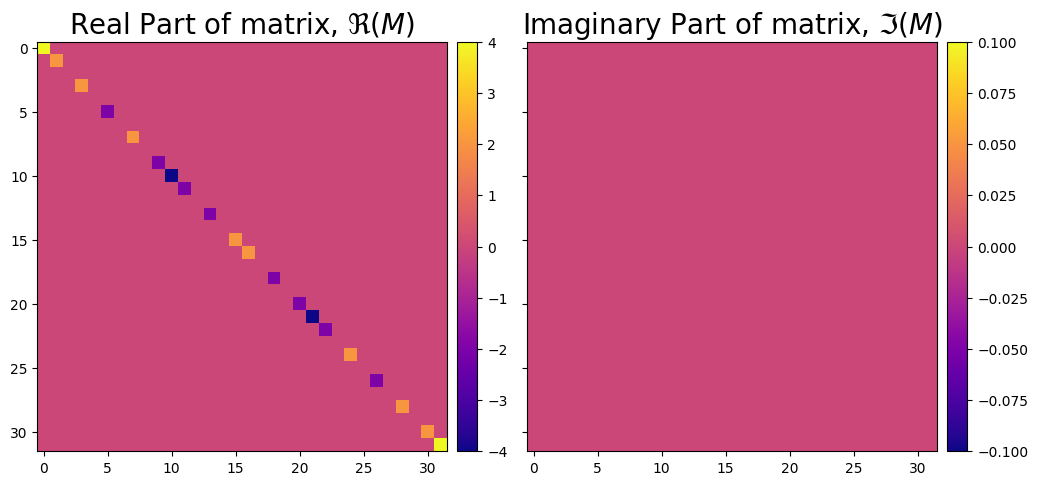

In [ ]:
pauli = np.array((((0, 1), (1, 0)), ((0, -1j), (1j, 0)), ((1, 0), (0, -1))))
I2 = np.eye(2)

#generate list of length L for pauli x,y, or z matrices for the qubit in the nth position of the list.
def paulilist(n: int, L: int):
    s=[]
    for i in range(1,L+1):
        mat = pauli[n-1] if i == 1 else I2
        for j in range(1,L):
            if i==j+1:
                mat = np.kron(mat, pauli[n-1])
            else:
                mat = np.kron(mat, I2)
        s.append(mat)
    return s

#Define Hbond function
def Hbond(L):
  pz = paulilist(3, L)
  hbondsum = np.zeros((2**L,2**L))
  for i in range(0,L-1):
    hbondsum = np.add(hbondsum, pz[i]@pz[i+1])
  return hbondsum

heatmap2d(Hbond(5))

3. Hfield function

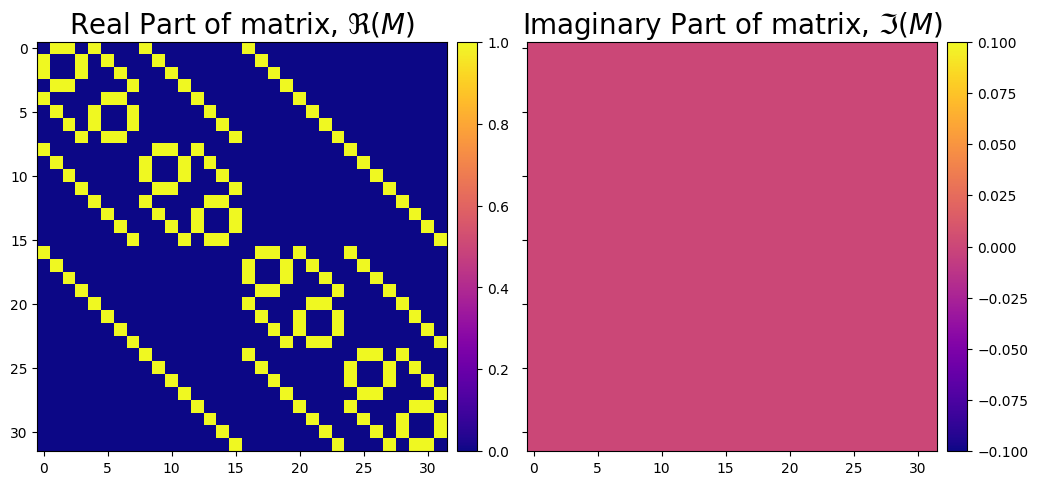

In [ ]:
#Define Hbond function
def Hfield(L):
  px = paulilist(1, L)
  return sum(px)

heatmap2d(Hfield(5))

4. Sparse Hbond and Hfield functions

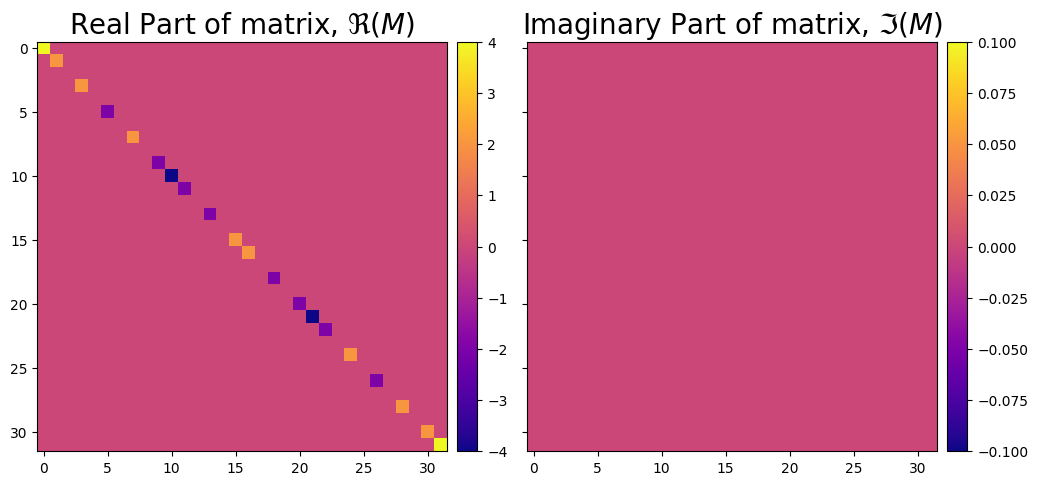

In [ ]:
def Hbond_sparse(L):
  zlist = gen_s0sxsysz(L)[3]
  tot = sparse.csr_matrix(np.zeros([2**L, 2**L]))
  for i in range(0, L-1):
    tot += zlist[i]*zlist[i+1]
  return tot

heatmap2d(Hbond_sparse(5).toarray())

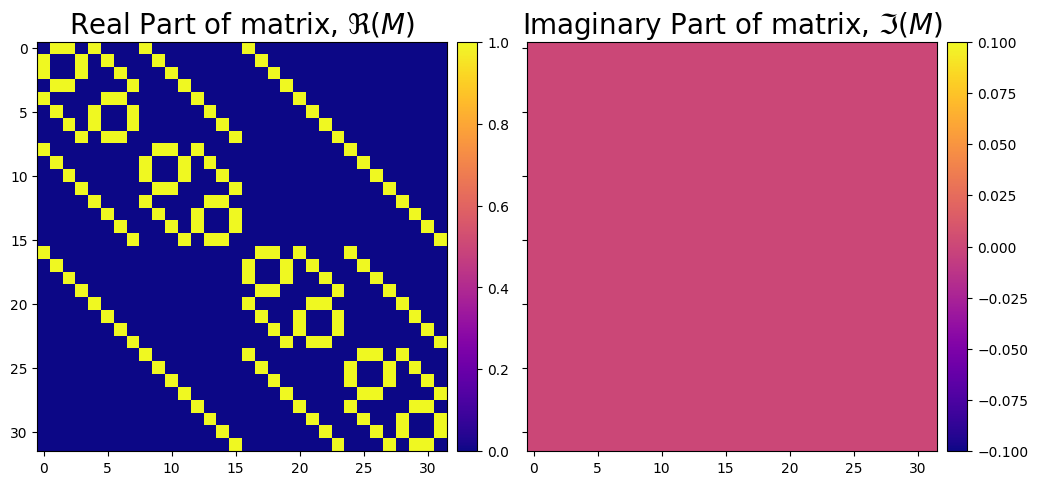

In [ ]:
def Hfield_sparse(L):
  xlist = gen_s0sxsysz(L)[1]
  return sum(xlist)

heatmap2d(Hfield_sparse(5).toarray())

At a quantum phase transition, the gap between the ground and first excited state goes to zero. Let's look at this.

5. Set $J=1, L=8$. Construct the Hamiltonian using sparse methods i.e. using the functions Hbond_sparse and Hfield_sparse defined above. Obtain and plot the lowest two energy eigenvalues of the Hamiltonian as a function of $H$. Do do this, you can the Hamiltonian to a dense matrix using .toarray() function, and then use linalg.eigvalsh to obtain the eigenvalues of the dense matrix. Do you see the gap closing at $h=0$? (3 pts)

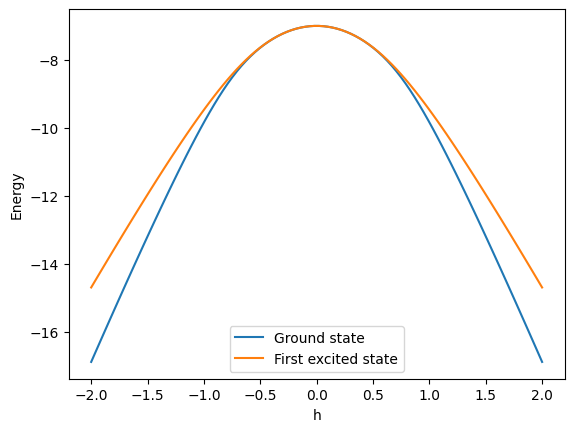

In [ ]:
def Hamiltonian(h, L):
    return (- Hbond_sparse(L) - h*Hfield_sparse(L))
Hlist = []
hvals = np.linspace(-2,2, 100)
[Hlist.append(Hamiltonian(h, 8)) for h in hvals]
eval_list = []
[eval_list.append(linalg.eigh(H.toarray())[0][0:2]) for H in Hlist]
plt.plot(hvals, eval_list)
plt.xlabel("h")
plt.ylabel("Energy")
plt.legend(["Ground state", "First excited state"])

Thus far, we only used sparse methods to construct the Hamiltonian, but thereafter proceeded to do full dense diagonalization to get the entire many-body spectrum. However, often one is interested in only the ground-state or a few low-lying states, in which case sparse eigensolvers can give a sizeable speedup.



```
import scipy.sparse.linalg as spalin
evals2, evecs2=spalin.eigsh(H, k=4, which='SA')
evals, evecs = linalg.eigh(H.toarray())
evals2
evals[0:4]
```



We plot the ground state and first excited state energies using sparse methods and see that it matches.

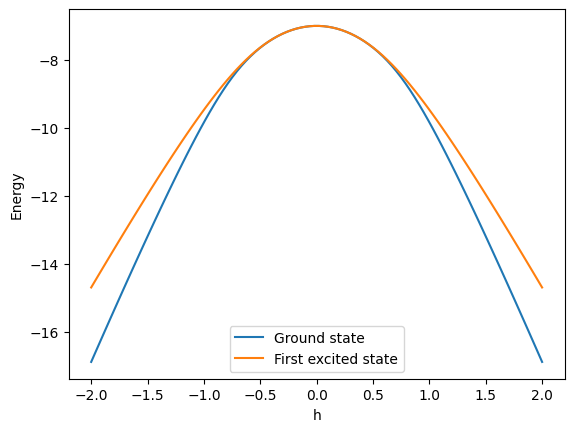

In [ ]:
import scipy.sparse.linalg as spalin

eval_list2 = []
[eval_list2.append(spalin.eigsh(H, k=2, which='SA')[0]) for H in Hlist]
plt.plot(hvals, eval_list2)
plt.xlabel("h")
plt.ylabel("Energy")
plt.legend(["Ground state", "First excited state"])

In [ ]:
spalin.eigsh(Hlist[0], k=4, which='SA')[0]

array([-7., -7., -5., -5.])

# Exercises (5pts)

In the following, assume that the system is described a chain of spin-$1/2$ particles of length $L$.

1. How do the run-times for sparse and dense matrix diagonalizations scale with $N$, the size of the matrix? Is sparse diagonalization always faster? If not, how large does $L$ have to be for sparse methods to win? (Hint: you many find the timeit module useful) (3 pts)
2. The toarray() function converts the sparse matrix to a dense numpy array. How much memory do you need to store such an array as a function of $L$? (1pt)
3. What is the maximum $L$ you can diagonalize on your laptop (you will need to check how much RAM you have)? (1pt)

In [ ]:
Hsizes = []
Lvals = np.arange(2, 12)
[Hsizes.append(Hamiltonian(1, L)) for L in Lvals]
import timeit

def denseDiag(h_):
  a, b = linalg.eigh(h_.toarray())

def sparseDiag(h_, L):
  a = spalin.eigsh(h_, k=L-1)[0]

denseTimes = []
sparseTimes = []
for Ls in Lvals:
  tD = timeit.Timer(lambda: denseDiag(Hsizes[Ls-2]))
  denseTimes.append(tD.timeit(number=1))
  tS = timeit.Timer(lambda: sparseDiag(Hsizes[Ls-2], Ls))
  sparseTimes.append(tS.timeit(number=1))

denseTimes

[0.00039019300038489746,
 0.0002865129999918281,
 0.00026078199971379945,
 0.0004520310003499617,
 0.003630463000263262,
 0.013345790999665041,
 0.020602773999598867,
 0.13791634700010036,
 1.344841983999686,
 6.693283994000012]

In [ ]:
sparseTimes

[0.0007091769994076458,
 0.0006802380003136932,
 0.0009673310005382518,
 0.00268090499957907,
 0.004703439000877552,
 0.006706756000312453,
 0.013784779999696184,
 0.01766602200041234,
 0.04770305400052166,
 0.07133671300016431]

Text(0, 0.5, 'log(t)')

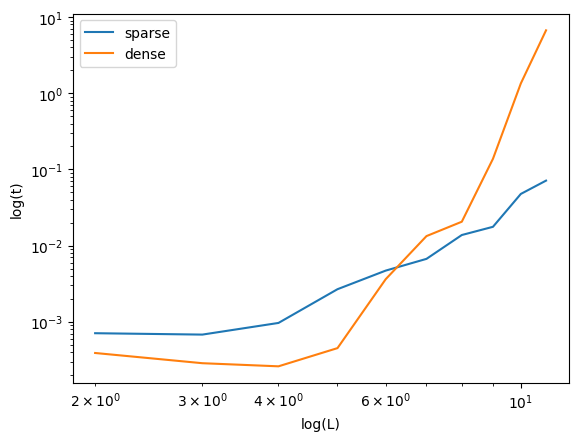

In [ ]:
plt.loglog(Lvals, sparseTimes, label="sparse")
plt.loglog(Lvals, denseTimes, label="dense")
plt.legend()
plt.xlabel("log(L)")
plt.ylabel("log(t)")

Text(0, 0.5, 't')

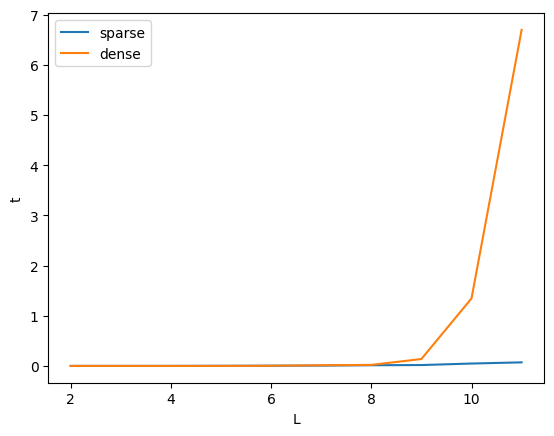

In [ ]:
plt.plot(Lvals, sparseTimes, label="sparse")
plt.plot(Lvals, denseTimes, label="dense")
plt.legend()
plt.xlabel("L")
plt.ylabel("t")

As we can see, the dense diagonalization appears to be exponential with N, whereas the sparse matrix is subexponential and looks approximately linear. We can see that at around L=6, the sparse methods start to win over the dense methods.

```
# This is formatted as code
```



In [ ]:
Hsizes[0].toarray().itemsize

8

The number of entries of our matrices scale as $4^L$. Each entry takes 8 bytes of memory to store, so we need $8 \times 4^L$ bytes.

I have 16 GB of RAM, so log base 4 of (16E9 / 8) is ~15.4. Thus the max size I can diagonalize is $L=15$.